# Graph Neural Network for Human vs LLM Code Classification

This notebook implements a GIN (Graph Isomorphism Network) to distinguish between human-written and LLM-generated Python code using Abstract Syntax Tree (AST) representations.

## 1. Setup and Imports

In [ ]:
!python3 --version

Python 3.8.20


In [ ]:
!pip install matplotlib

In [ ]:
!pip install scikit-learn

In [ ]:
!pip install seaborn

In [ ]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_auc_score, roc_curve


In [ ]:
# Import custom modules
from graphdataset import CodeGraphDataset

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## 2. Data Loading and Exploration

In [ ]:
# Configuration
DATA_DIR = 'dataset/python'
TRAIN_FILE = os.path.join(DATA_DIR, 'train.jsonl')
VALID_FILE = os.path.join(DATA_DIR, 'valid.jsonl')
TEST_FILE = os.path.join(DATA_DIR, 'test_no_comment.jsonl')

MAX_NODES = 500  # Maximum nodes in AST
EMBEDDING_SIZE = 128  # Dimension of node embeddings
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_EPOCHS = 30
HIDDEN_DIM = 256
NUM_LAYERS = 5

# NEW: Optimization parameters
MAX_SAMPLES_TRAIN = None  # Limit training samples (None = all)
MAX_SAMPLES_TEST = None   # Limit test samples (None = all)
TIMEOUT_MINUTES = 10      # Stop processing after 10 minutes

print("Configuration:")
print(f"  Max nodes: {MAX_NODES}")
print(f"  Embedding size: {EMBEDDING_SIZE}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Hidden dim: {HIDDEN_DIM}")
print(f"  GIN layers: {NUM_LAYERS}")
print(f"  Max training samples: {MAX_SAMPLES_TRAIN}")
print(f"  Max test samples: {MAX_SAMPLES_TEST}")
print(f"  Timeout: {TIMEOUT_MINUTES} minutes")



NameError: name 'os' is not defined

In [ ]:
# Load datasets with limits and timeout
# print("\n" + "="*70)
# print("Loading train dataset...")
# print("="*70)
# train_dataset = CodeGraphDataset(
#     jsonl_path=TRAIN_FILE,
#     max_nodes=MAX_NODES,
#     embedding_size=EMBEDDING_SIZE,
#     force_reprocess=False,
#     max_samples=MAX_SAMPLES_TRAIN,  # LIMIT SAMPLES
#     timeout_minutes=TIMEOUT_MINUTES  # TIMEOUT
# )

print("\n" + "="*70)
print("Loading validation dataset...")
print("="*70)
valid_dataset = CodeGraphDataset(
    jsonl_path=VALID_FILE,
    max_nodes=MAX_NODES,
    embedding_size=EMBEDDING_SIZE,
    force_reprocess=False,
    max_samples=MAX_SAMPLES_TRAIN,  # LIMIT SAMPLES
    timeout_minutes=TIMEOUT_MINUTES  # TIMEOUT
)

print("\n" + "="*70)
print("Loading test dataset (sharing vocabulary)...")
print("="*70)
test_dataset = CodeGraphDataset(
    jsonl_path=TEST_FILE,
    processor=valid_dataset.processor,  # Share vocabulary
    max_nodes=MAX_NODES,
    max_samples=MAX_SAMPLES_TEST,  # LIMIT SAMPLES
    timeout_minutes=TIMEOUT_MINUTES  # TIMEOUT
)

print(f"\n{'='*70}")
print(f"Validation set size: {len(valid_dataset)}")
print(f"Test set size: {len(test_dataset)}")
print(f"{'='*70}")


Loading train dataset...
Processing graphs from dataset/python/train.jsonl
  Limiting to 50000 samples
  Timeout: 10 minutes
Loaded 50000 examples from dataset/python/train.jsonl
Extracting AST node sequences from corpus...


Extracting tokens:   0%|          | 1/500 [00:20<2:53:08, 20.82s/batch]

Conversion failed for snippet: bad input: type=1, value='num_left', context=('  \n        # Need to get any partial lines\n        ', (15, 8))
Syntax error in code: invalid syntax (<unknown>, line 15)
Conversion failed for snippet: bad input: type=11, value=':', context=('', (17, 19))
Syntax error in code: invalid syntax (<unknown>, line 17)
Conversion failed for snippet: bad input: type=1, value='def', context=('# additional type)\n        ', (11, 8))
Syntax error in code: invalid syntax (<unknown>, line 11)


Extracting tokens:   0%|          | 2/500 [00:40<2:46:22, 20.04s/batch]

Conversion failed for snippet: bad input: type=22, value='=', context=('', (12, 50))
Conversion failed for snippet: bad input: type=1, value='right_padding', context=(' \n        ', (16, 8))
Syntax error in code: invalid syntax (<unknown>, line 16)
Conversion failed for snippet: bad input: type=4, value='\n', context=('', (6, 65))
Syntax error in code: invalid syntax (<unknown>, line 6)


Extracting tokens:   1%|          | 3/500 [01:00<2:46:08, 20.06s/batch]

Conversion failed for snippet: bad input: type=4, value='\n', context=(' # implementation', (4, 42))
Syntax error in code: invalid syntax (<unknown>, line 4)


Extracting tokens:   1%|          | 4/500 [01:20<2:45:51, 20.06s/batch]

Conversion failed for snippet: bad input: type=11, value=':', context=('', (28, 50))
Syntax error in code: invalid syntax (<unknown>, line 28)
Conversion failed for snippet: bad input: type=22, value='=', context=('', (17, 18))
Conversion failed for snippet: bad input: type=1, value='start', context=('  \n        ', (18, 8))
Syntax error in code: invalid syntax (<unknown>, line 18)


Extracting tokens:   1%|          | 6/500 [02:00<2:45:44, 20.13s/batch]

Conversion failed for snippet: bad input: type=1, value='except', context=('        # Code to send message to websocket goes here\n    ', (4, 4))
Syntax error in code: expected an indented block (<unknown>, line 4)
Conversion failed for snippet: bad input: type=1, value='hep_pos', context=('  \n        ', (17, 8))
Syntax error in code: invalid syntax (<unknown>, line 17)
Conversion failed for snippet: bad input: type=1, value='assert', context=(' \n        ', (11, 8))
Syntax error in code: invalid syntax (<unknown>, line 11)


Extracting tokens:   1%|▏         | 7/500 [02:20<2:44:23, 20.01s/batch]

Conversion failed for snippet: bad input: type=1, value='indy', context=(' ', (3, 29))
Conversion failed for snippet: bad input: type=1, value='return', context=('\n    ', (15, 4))
Syntax error in code: invalid syntax (<unknown>, line 15)
Conversion failed for snippet: bad input: type=1, value='else', context=('  \n        ', (18, 8))
Syntax error in code: invalid syntax (<unknown>, line 18)
Conversion failed for snippet: bad token: type=58, value=' ', context=('', (2, 62))
Syntax error in code: EOL while scanning string literal (<unknown>, line 2)
Conversion failed for snippet: bad token: type=58, value=' ', context=('', (38, 24))
Syntax error in code: EOL while scanning string literal (<unknown>, line 38)


Extracting tokens:   2%|▏         | 8/500 [02:40<2:42:56, 19.87s/batch]

Conversion failed for snippet: bad input: type=1, value='lat', context=('  \n        ', (49, 8))
Syntax error in code: invalid syntax (<unknown>, line 49)
Conversion failed for snippet: bad input: type=1, value='except', context=('            # Destroy the node\n        ', (6, 8))
Syntax error in code: expected an indented block (<unknown>, line 6)
Syntax error in code: invalid syntax (<unknown>, line 3)


Extracting tokens:   2%|▏         | 9/500 [03:00<2:43:11, 19.94s/batch]

Conversion failed for snippet: bad input: type=22, value='=', context=('', (125, 65))
Conversion failed for snippet: bad input: type=1, value='send_capabilities_request_legacy', context=('    # implementation of send_capabilities_request\n\n', (4, 0))
Syntax error in code: expected an indented block (<unknown>, line 4)


Extracting tokens:   2%|▏         | 10/500 [03:19<2:41:16, 19.75s/batch]

Conversion failed for snippet: bad input: type=1, value='return', context=('  \n    ', (5, 4))
Syntax error in code: invalid syntax (<unknown>, line 5)
Conversion failed for snippet: bad input: type=1, value='s', context=(' \n            ', (50, 12))
Syntax error in code: invalid syntax (<unknown>, line 50)
Conversion failed for snippet: bad input: type=22, value='=', context=('', (81, 33))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (7, 63))


Extracting tokens:   2%|▏         | 11/500 [03:39<2:40:47, 19.73s/batch]

Conversion failed for snippet: bad input: type=24, value='%', context=('    ', (5, 4))
Syntax error in code: invalid syntax (<unknown>, line 5)
Conversion failed for snippet: bad input: type=4, value='\n', context=(' # some code to fetch view_pcap object', (3, 53))
Syntax error in code: invalid syntax (<unknown>, line 3)


Extracting tokens:   3%|▎         | 13/500 [04:18<2:38:57, 19.58s/batch]

Conversion failed for snippet: bad input: type=22, value='=', context=('', (20, 38))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (17, 31))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (134, 48))


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x1086ce460>>
Traceback (most recent call last):
  File "/Users/nishka/miniconda3/envs/cs224w/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


Conversion failed for snippet: bad input: type=1, value='print', context=(' ', (1, 4))


Extracting tokens:   3%|▎         | 14/500 [04:38<2:40:19, 19.79s/batch]

Conversion failed for snippet: bad input: type=22, value='=', context=('', (32, 25))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (6, 31))
Conversion failed for snippet: bad input: type=1, value='def', context=('    # BrowserWindow class implementation\n\n', (6, 0))
Syntax error in code: expected an indented block (<unknown>, line 6)
Conversion failed for snippet: bad input: type=4, value='\n', context=(' # Calculation to convert temperature from pressure sensor to Celsius goes here', (3, 104))
Syntax error in code: invalid syntax (<unknown>, line 3)


In [ ]:
# Display dataset statistics
print("\n" + "="*70)
print("VALIDATION DATASET STATISTICS")
print("="*70)
valid_stats = valid_dataset.get_stats()
for key, value in valid_stats.items():
    if isinstance(value, float):
        print(f"{key}: {value:.2f}")
    else:
        print(f"{key}: {value}")

print("\n" + "="*70)
print("TEST DATASET STATISTICS")
print("="*70)
test_stats = test_dataset.get_stats()
for key, value in test_stats.items():
    if isinstance(value, float):
        print(f"{key}: {value:.2f}")
    else:
        print(f"{key}: {value}")


VALIDATION DATASET STATISTICS
total_samples: 656
avg_code_nodes: 39.79
max_code_nodes: 376
min_code_nodes: 3
avg_contrast_nodes: 43.39
max_contrast_nodes: 412
min_contrast_nodes: 3
label_distribution: {'label_0': 318, 'label_1': 338}

TEST DATASET STATISTICS
total_samples: 643
avg_code_nodes: 41.67
max_code_nodes: 476
min_code_nodes: 3
avg_contrast_nodes: 40.67
max_contrast_nodes: 347
min_contrast_nodes: 3
label_distribution: {'label_0': 313, 'label_1': 330}


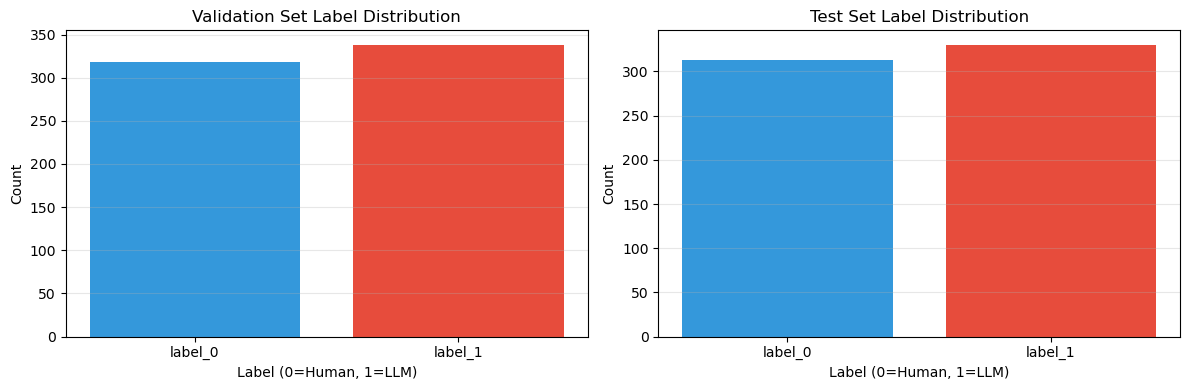

In [ ]:
# Visualize label distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Validation set
valid_labels = valid_stats['label_distribution']
axes[0].bar(valid_labels.keys(), valid_labels.values(), color=['#3498db', '#e74c3c'])
axes[0].set_title('Validation Set Label Distribution')
axes[0].set_xlabel('Label (0=Human, 1=LLM)')
axes[0].set_ylabel('Count')
axes[0].grid(axis='y', alpha=0.3)

# Test set
test_labels = test_stats['label_distribution']
axes[1].bar(test_labels.keys(), test_labels.values(), color=['#3498db', '#e74c3c'])
axes[1].set_title('Test Set Label Distribution')
axes[1].set_xlabel('Label (0=Human, 1=LLM)')
axes[1].set_ylabel('Count')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('label_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# Examine a sample
sample = valid_dataset[0]
print("\n" + "="*70)
print("SAMPLE DATA POINT")
print("="*70)
print(f"Index: {sample['index']}")
print(f"Label: {sample['label'].item()} ({'Human' if sample['label'].item() == 0 else 'LLM'})")
print(f"\nCode Graph:")
print(f"  Shape: {sample['code_graph'].shape}")
print(f"  Number of nodes: {sample['code_num_nodes']}")
print(f"  Sequence length: {len(sample['code_sequence'])}")
print(f"  First 15 tokens: {sample['code_sequence'][:15]}")
print(f"\nContrast Graph:")
print(f"  Shape: {sample['contrast_graph'].shape}")
print(f"  Number of nodes: {sample['contrast_num_nodes']}")
print(f"  Sequence length: {len(sample['contrast_sequence'])}")
print(f"  First 15 tokens: {sample['contrast_sequence'][:15]}")


SAMPLE DATA POINT
Index: gp266290
Label: 1 (LLM)

Code Graph:
  Shape: torch.Size([500, 500])
  Number of nodes: 13
  Sequence length: 13
  First 15 tokens: [7, 6, 5, 1, 4, 3, 1, 0, 1, 0, 8, 1, 0]

Contrast Graph:
  Shape: torch.Size([500, 500])
  Number of nodes: 57
  Sequence length: 57
  First 15 tokens: [7, 6, 12, 3, 2, 1, 0, 0, 3, 2, 2449, 0, 1, 0, 5]


In [ ]:
# Get embedding matrix
embedding_matrix = valid_dataset.get_embedding_matrix()
print(f"\nEmbedding matrix shape: {embedding_matrix.shape}")
print(f"Vocabulary size: {embedding_matrix.shape[0] - 1}")


Embedding matrix shape: torch.Size([5960, 128])
Vocabulary size: 5959


## 3. GIN Model Architecture

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GINLayer(nn.Module):
    """Graph Isomorphism Network Layer.
    
    Implements: h_v^(k) = MLP^(k)((1 + epsilon^(k)) * h_v^(k-1) + sum_{u in N(v)} h_u^(k-1))
    """
    def __init__(self, input_dim, hidden_dim, output_dim, eps_learnable=True):
        super(GINLayer, self).__init__()
        
        # MLP for node update
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.BatchNorm1d(output_dim),
            nn.ReLU()
        )
        
        # Learnable epsilon parameter
        if eps_learnable:
            self.eps = nn.Parameter(torch.zeros(1))
        else:
            self.register_buffer('eps', torch.zeros(1))
    
    def forward(self, x, adj):
        """
        Args:
            x: Node features [batch_size, num_nodes, feature_dim]
            adj: Adjacency matrix [batch_size, num_nodes, num_nodes]
        
        Returns:
            Updated node features [batch_size, num_nodes, output_dim]
        """
        # Extract dimensions FIRST (critical!)
        batch_size, num_nodes, feature_dim = x.size()
        
        # Aggregate neighbor features: sum_{u in N(v)} h_u
        neighbor_sum = torch.bmm(adj, x)  # [batch_size, num_nodes, feature_dim]
        
        # Remove self-loop from aggregation (we'll add it back with epsilon)
        # Create diagonal mask for each batch
        eye = torch.eye(num_nodes, device=adj.device).unsqueeze(0).expand(batch_size, -1, -1)
        self_features = torch.bmm(eye, x)
        neighbor_sum = neighbor_sum - self_features
        
        # Apply GIN update rule: (1 + eps) * h + sum(neighbors)
        out = (1 + self.eps) * x + neighbor_sum
        
        # Apply MLP
        out = out.view(batch_size * num_nodes, feature_dim)
        out = self.mlp(out)
        out = out.view(batch_size, num_nodes, -1)
        
        return out


class GINNetwork(nn.Module):
    """Graph Isomorphism Network for code classification."""
    
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, 
                 num_classes=2, dropout=0.3, pretrained_embeddings=None):
        super(GINNetwork, self).__init__()
        
        self.num_layers = num_layers
        self.dropout = dropout
        
        # Token embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        if pretrained_embeddings is not None:
            self.embedding.weight.data.copy_(pretrained_embeddings)
            # Optionally freeze embeddings
            # self.embedding.weight.requires_grad = False
        
        # GIN layers
        self.gin_layers = nn.ModuleList()
        
        # First layer
        self.gin_layers.append(
            GINLayer(embedding_dim, hidden_dim, hidden_dim, eps_learnable=True)
        )
        
        # Hidden layers
        for _ in range(num_layers - 1):
            self.gin_layers.append(
                GINLayer(hidden_dim, hidden_dim, hidden_dim, eps_learnable=True)
            )
        
        # Readout MLP (for graph-level classification)
        self.readout = nn.Sequential(
            nn.Linear(hidden_dim * num_layers, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )
    
    def forward(self, sequences, adj_matrices, num_nodes_list):
        """
        Args:
            sequences: LIST of token sequences (Python lists!)
            adj_matrices: Adjacency matrices [batch_size, max_nodes, max_nodes]
            num_nodes_list: List of actual number of nodes
        
        Returns:
            logits: [batch_size, num_classes]
        """
        batch_size = adj_matrices.size(0)
        max_nodes = adj_matrices.size(1)
        
        # FIX: Convert list of sequences to padded tensor
        node_features = torch.zeros(batch_size, max_nodes, dtype=torch.long, 
                                    device=adj_matrices.device)
        
        for i, seq in enumerate(sequences):
            seq_len = min(len(seq), max_nodes)
            node_features[i, :seq_len] = torch.tensor(seq[:seq_len], 
                                                    dtype=torch.long, 
                                                    device=adj_matrices.device)
        
        # Embed tokens
        x = self.embedding(node_features)
        
        # Apply GIN layers
        layer_outputs = []
        for layer in self.gin_layers:
            x = layer(x, adj_matrices)
            x = F.dropout(x, p=self.dropout, training=self.training)
            layer_outputs.append(x)
        
        # Graph-level readout with masking
        graph_representations = []
        for layer_out in layer_outputs:
            mask = torch.zeros(batch_size, max_nodes, 1, device=layer_out.device)
            for i, num_nodes in enumerate(num_nodes_list):
                mask[i, :num_nodes, :] = 1.0
            
            masked_out = layer_out * mask
            graph_rep = masked_out.sum(dim=1)
            graph_representations.append(graph_rep)
        
        # Concatenate and classify
        graph_rep = torch.cat(graph_representations, dim=1)
        logits = self.readout(graph_rep)
        
        return logits


class SiameseGNN(nn.Module):
    """Siamese network for comparing code and contrast samples."""
    
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers,
                 num_classes=2, dropout=0.3, pretrained_embeddings=None):
        super(SiameseGNN, self).__init__()
        
        # Shared GNN encoder
        self.gnn = GINNetwork(
            vocab_size=vocab_size,
            embedding_dim=embedding_dim,
            hidden_dim=hidden_dim,
            num_layers=num_layers,
            num_classes=hidden_dim * num_layers,  # Output embedding instead of class
            dropout=dropout,
            pretrained_embeddings=pretrained_embeddings
        )
        
        # Classifier on combined representations
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * num_layers * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )
    
    def forward(self, code_seq, code_adj, code_num_nodes,
                contrast_seq, contrast_adj, contrast_num_nodes):
        """
        Args:
            code_seq: Token sequences for code [batch_size, max_seq_len]
            code_adj: Adjacency matrices for code [batch_size, max_nodes, max_nodes]
            code_num_nodes: Number of nodes for each code graph [batch_size]
            contrast_seq: Token sequences for contrast [batch_size, max_seq_len]
            contrast_adj: Adjacency matrices for contrast [batch_size, max_nodes, max_nodes]
            contrast_num_nodes: Number of nodes for each contrast graph [batch_size]
        
        Returns:
            logits: [batch_size, num_classes]
        """
        # Encode both graphs
        code_embedding = self.gnn(code_seq, code_adj, code_num_nodes)
        contrast_embedding = self.gnn(contrast_seq, contrast_adj, contrast_num_nodes)
        
        # Concatenate embeddings
        combined = torch.cat([code_embedding, contrast_embedding], dim=1)
        
        # Classify
        logits = self.classifier(combined)
        
        return logits


print("GIN Model Architecture defined successfully!")

GIN Model Architecture defined successfully!


## 4. Training Setup

In [ ]:
def collate_code_batch(batch):
    """Custom collate function to handle variable-length sequences."""
    indices = [item['index'] for item in batch]
    labels = torch.stack([item['label'] for item in batch])
    code_graphs = torch.stack([item['code_graph'] for item in batch])
    contrast_graphs = torch.stack([item['contrast_graph'] for item in batch])
    code_num_nodes = [item['code_num_nodes'] for item in batch]
    contrast_num_nodes = [item['contrast_num_nodes'] for item in batch]
    code_sequences = [item['code_sequence'] for item in batch]
    contrast_sequences = [item['contrast_sequence'] for item in batch]
    
    return {
        'index': indices,
        'label': labels,
        'code_graph': code_graphs,
        'contrast_graph': contrast_graphs,
        'code_num_nodes': code_num_nodes,
        'contrast_num_nodes': contrast_num_nodes,
        'code_sequence': code_sequences,
        'contrast_sequence': contrast_sequences
    }

# Create data loaders WITH CUSTOM COLLATE FUNCTION
train_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_code_batch  # ← KEY FIX
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_code_batch  # ← KEY FIX
)

print(f"Train batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 21
Test batches: 21


In [ ]:
# Initialize model
vocab_size = embedding_matrix.shape[0]

model = SiameseGNN(
    vocab_size=vocab_size,
    embedding_dim=EMBEDDING_SIZE,
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS,
    num_classes=2,
    dropout=0.3,
    pretrained_embeddings=embedding_matrix
).to(device)

print(f"\nModel initialized with {sum(p.numel() for p in model.parameters()):,} parameters")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")


Model initialized with 2,706,183 parameters
Trainable parameters: 2,706,183


In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=5, verbose=True
)

print("Training setup complete!")

Training setup complete!


/Users/alexandrakim/opt/anaconda3/envs/CS224W/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


## 5. Training Loop

In [ ]:
def train_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch."""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    progress_bar = tqdm(loader, desc='Training', leave=False)
    
    for batch in progress_bar:
        # Move data to device
        code_graph = batch['code_graph'].to(device)
        contrast_graph = batch['contrast_graph'].to(device)
        labels = batch['label'].to(device)
        
        code_num_nodes = batch['code_num_nodes']
        contrast_num_nodes = batch['contrast_num_nodes']
        
        code_seq = batch['code_sequence']
        contrast_seq = batch['contrast_sequence']
        
        # Forward pass
        optimizer.zero_grad()
        logits = model(
            code_seq, code_graph, code_num_nodes,
            contrast_seq, contrast_graph, contrast_num_nodes
        )
        
        loss = criterion(logits, labels)
        
        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        # Statistics
        total_loss += loss.item()
        _, predicted = torch.max(logits, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        
        # Update progress bar
        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100 * correct / total:.2f}%'
        })
    
    avg_loss = total_loss / len(loader)
    accuracy = 100 * correct / total
    
    return avg_loss, accuracy


def evaluate(model, loader, criterion, device):
    """Evaluate model on validation/test set."""
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for batch in tqdm(loader, desc='Evaluating', leave=False):
            # Move data to device
            code_graph = batch['code_graph'].to(device)
            contrast_graph = batch['contrast_graph'].to(device)
            labels = batch['label'].to(device)
            
            code_num_nodes = batch['code_num_nodes']
            contrast_num_nodes = batch['contrast_num_nodes']
            
            code_seq = batch['code_sequence']
            contrast_seq = batch['contrast_sequence']
            
            # Forward pass
            logits = model(
                code_seq, code_graph, code_num_nodes,
                contrast_seq, contrast_graph, contrast_num_nodes
            )
            
            loss = criterion(logits, labels)
            total_loss += loss.item()
            
            # Get predictions and probabilities
            probs = F.softmax(logits, dim=1)
            _, predicted = torch.max(logits, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())  # Probability of class 1
    
    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='binary', zero_division=0
    )
    
    try:
        auc = roc_auc_score(all_labels, all_probs)
    except:
        auc = 0.0
    
    return {
        'loss': avg_loss,
        'accuracy': accuracy * 100,
        'precision': precision * 100,
        'recall': recall * 100,
        'f1': f1 * 100,
        'auc': auc,
        'predictions': all_preds,
        'labels': all_labels,
        'probabilities': all_probs
    }


print("Training functions defined!")

Training functions defined!


In [ ]:
# Training loop
train_losses = []
train_accs = []
test_losses = []
test_accs = []
test_f1s = []

best_test_f1 = 0
best_model_state = None

print("Starting training...\n")

for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 70)
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Evaluate
    test_metrics = evaluate(model, test_loader, criterion, device)
    test_losses.append(test_metrics['loss'])
    test_accs.append(test_metrics['accuracy'])
    test_f1s.append(test_metrics['f1'])
    
    # Print metrics
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Test Loss:  {test_metrics['loss']:.4f} | Test Acc:  {test_metrics['accuracy']:.2f}%")
    print(f"Test Precision: {test_metrics['precision']:.2f}% | Test Recall: {test_metrics['recall']:.2f}%")
    print(f"Test F1: {test_metrics['f1']:.2f}% | Test AUC: {test_metrics['auc']:.4f}")
    
    # Learning rate scheduling
    scheduler.step(test_metrics['f1'])
    
    # Save best model
    if test_metrics['f1'] > best_test_f1:
        best_test_f1 = test_metrics['f1']
        best_model_state = model.state_dict().copy()
        print(f"*** New best F1: {best_test_f1:.2f}% ***")
    
    print()

print(f"\nTraining complete! Best test F1: {best_test_f1:.2f}%")

# Load best model
model.load_state_dict(best_model_state)
torch.save(best_model_state, 'best_model.pth')
print("Best model saved to 'best_model.pth'")

Starting training...

Epoch 1/30
----------------------------------------------------------------------


Train Loss: 7.6611 | Train Acc: 68.75%
Test Loss:  0.9340 | Test Acc:  71.54%
Test Precision: 67.21% | Test Recall: 86.97%
Test F1: 75.83% | Test AUC: 0.8073
*** New best F1: 75.83% ***

Epoch 2/30
----------------------------------------------------------------------


Train Loss: 0.6813 | Train Acc: 78.51%
Test Loss:  0.3660 | Test Acc:  86.31%
Test Precision: 85.17% | Test Recall: 88.79%
Test F1: 86.94% | Test AUC: 0.9268
*** New best F1: 86.94% ***

Epoch 3/30
----------------------------------------------------------------------


Train Loss: 0.6427 | Train Acc: 78.20%
Test Loss:  0.5352 | Test Acc:  87.71%
Test Precision: 87.69% | Test Recall: 88.48%
Test F1: 88.08% | Test AUC: 0.9417
*** New best F1: 88.08% ***

Epoch 4/30
----------------------------------------------------------------------


Train Loss: 0.4779 | Train Acc: 81.40%
Test Loss:  1.5039 | Test Acc:  85.85%
Test Precision: 91.64% | Test Recall: 79.70%
Test F1: 85.25% | Test AUC: 0.9341

Epoch 5/30
----------------------------------------------------------------------


Train Loss: 0.4993 | Train Acc: 80.95%
Test Loss:  2.1338 | Test Acc:  67.96%
Test Precision: 84.44% | Test Recall: 46.06%
Test F1: 59.61% | Test AUC: 0.7876

Epoch 6/30
----------------------------------------------------------------------


Train Loss: 0.6555 | Train Acc: 75.91%
Test Loss:  0.3133 | Test Acc:  86.31%
Test Precision: 83.24% | Test Recall: 91.82%
Test F1: 87.32% | Test AUC: 0.9469

Epoch 7/30
----------------------------------------------------------------------


Train Loss: 0.5903 | Train Acc: 79.88%
Test Loss:  0.5486 | Test Acc:  66.72%
Test Precision: 60.70% | Test Recall: 99.70%
Test F1: 75.46% | Test AUC: 0.7668

Epoch 8/30
----------------------------------------------------------------------


Train Loss: 0.4526 | Train Acc: 81.55%
Test Loss:  0.4869 | Test Acc:  85.23%
Test Precision: 79.60% | Test Recall: 95.76%
Test F1: 86.93% | Test AUC: 0.9358

Epoch 9/30
----------------------------------------------------------------------


Train Loss: 0.5339 | Train Acc: 78.81%
Test Loss:  0.3263 | Test Acc:  83.98%
Test Precision: 78.30% | Test Recall: 95.15%
Test F1: 85.91% | Test AUC: 0.9372

Epoch 10/30
----------------------------------------------------------------------


Train Loss: 0.3594 | Train Acc: 82.32%
Test Loss:  0.3860 | Test Acc:  80.56%
Test Precision: 73.35% | Test Recall: 97.58%
Test F1: 83.75% | Test AUC: 0.9055

Epoch 11/30
----------------------------------------------------------------------


Train Loss: 0.3615 | Train Acc: 84.60%
Test Loss:  0.9172 | Test Acc:  84.45%
Test Precision: 84.02% | Test Recall: 86.06%
Test F1: 85.03% | Test AUC: 0.9061

Epoch 12/30
----------------------------------------------------------------------


Train Loss: 0.3621 | Train Acc: 83.54%
Test Loss:  0.3039 | Test Acc:  85.85%
Test Precision: 82.04% | Test Recall: 92.73%
Test F1: 87.06% | Test AUC: 0.9444

Epoch 13/30
----------------------------------------------------------------------


Train Loss: 0.3352 | Train Acc: 85.21%
Test Loss:  0.2538 | Test Acc:  88.65%
Test Precision: 86.20% | Test Recall: 92.73%
Test F1: 89.34% | Test AUC: 0.9639
*** New best F1: 89.34% ***

Epoch 14/30
----------------------------------------------------------------------


Train Loss: 0.2723 | Train Acc: 89.18%
Test Loss:  0.2580 | Test Acc:  89.27%
Test Precision: 88.27% | Test Recall: 91.21%
Test F1: 89.72% | Test AUC: 0.9601
*** New best F1: 89.72% ***

Epoch 15/30
----------------------------------------------------------------------


Train Loss: 0.2261 | Train Acc: 89.02%
Test Loss:  0.4671 | Test Acc:  86.31%
Test Precision: 82.35% | Test Recall: 93.33%
Test F1: 87.50% | Test AUC: 0.9419

Epoch 16/30
----------------------------------------------------------------------


Train Loss: 0.2437 | Train Acc: 90.24%
Test Loss:  0.3380 | Test Acc:  87.25%
Test Precision: 84.44% | Test Recall: 92.12%
Test F1: 88.12% | Test AUC: 0.9513

Epoch 17/30
----------------------------------------------------------------------


Train Loss: 0.2393 | Train Acc: 89.33%
Test Loss:  0.2998 | Test Acc:  86.94%
Test Precision: 82.71% | Test Recall: 94.24%
Test F1: 88.10% | Test AUC: 0.9510

Epoch 18/30
----------------------------------------------------------------------


Train Loss: 0.3141 | Train Acc: 88.57%
Test Loss:  0.3035 | Test Acc:  86.47%
Test Precision: 81.56% | Test Recall: 95.15%
Test F1: 87.83% | Test AUC: 0.9457

Epoch 19/30
----------------------------------------------------------------------


Train Loss: 0.2614 | Train Acc: 89.33%
Test Loss:  1.2133 | Test Acc:  86.47%
Test Precision: 88.82% | Test Recall: 84.24%
Test F1: 86.47% | Test AUC: 0.9394

Epoch 20/30
----------------------------------------------------------------------


Train Loss: 0.2995 | Train Acc: 89.94%
Test Loss:  0.6252 | Test Acc:  86.47%
Test Precision: 82.40% | Test Recall: 93.64%
Test F1: 87.66% | Test AUC: 0.9464

Epoch 21/30
----------------------------------------------------------------------


Train Loss: 0.2988 | Train Acc: 89.48%
Test Loss:  0.3411 | Test Acc:  86.94%
Test Precision: 81.70% | Test Recall: 96.06%
Test F1: 88.30% | Test AUC: 0.9515

Epoch 22/30
----------------------------------------------------------------------


Train Loss: 0.2106 | Train Acc: 91.77%
Test Loss:  0.3273 | Test Acc:  88.34%
Test Precision: 84.93% | Test Recall: 93.94%
Test F1: 89.21% | Test AUC: 0.9585

Epoch 23/30
----------------------------------------------------------------------


Train Loss: 0.2072 | Train Acc: 91.46%
Test Loss:  0.3988 | Test Acc:  89.11%
Test Precision: 88.92% | Test Recall: 90.00%
Test F1: 89.46% | Test AUC: 0.9616

Epoch 24/30
----------------------------------------------------------------------


Train Loss: 0.1978 | Train Acc: 91.62%
Test Loss:  0.3698 | Test Acc:  88.02%
Test Precision: 84.28% | Test Recall: 94.24%
Test F1: 88.98% | Test AUC: 0.9520

Epoch 25/30
----------------------------------------------------------------------


Train Loss: 0.2217 | Train Acc: 91.92%
Test Loss:  0.4379 | Test Acc:  88.18%
Test Precision: 86.71% | Test Recall: 90.91%
Test F1: 88.76% | Test AUC: 0.9553

Epoch 26/30
----------------------------------------------------------------------


Train Loss: 0.1817 | Train Acc: 92.07%
Test Loss:  0.3630 | Test Acc:  88.18%
Test Precision: 88.02% | Test Recall: 89.09%
Test F1: 88.55% | Test AUC: 0.9578

Epoch 27/30
----------------------------------------------------------------------


Train Loss: 0.1793 | Train Acc: 92.53%
Test Loss:  0.3766 | Test Acc:  86.94%
Test Precision: 83.24% | Test Recall: 93.33%
Test F1: 88.00% | Test AUC: 0.9554

Epoch 28/30
----------------------------------------------------------------------


Train Loss: 0.1838 | Train Acc: 90.40%
Test Loss:  0.4072 | Test Acc:  88.34%
Test Precision: 85.32% | Test Recall: 93.33%
Test F1: 89.15% | Test AUC: 0.9588

Epoch 29/30
----------------------------------------------------------------------


Train Loss: 0.2376 | Train Acc: 91.46%
Test Loss:  0.4669 | Test Acc:  87.87%
Test Precision: 85.39% | Test Recall: 92.12%
Test F1: 88.63% | Test AUC: 0.9600

Epoch 30/30
----------------------------------------------------------------------


Train Loss: 0.1418 | Train Acc: 93.60%
Test Loss:  0.5701 | Test Acc:  88.49%
Test Precision: 85.16% | Test Recall: 93.94%
Test F1: 89.34% | Test AUC: 0.9614


Training complete! Best test F1: 89.72%
Best model saved to 'best_model.pth'


## 6. Results Visualization

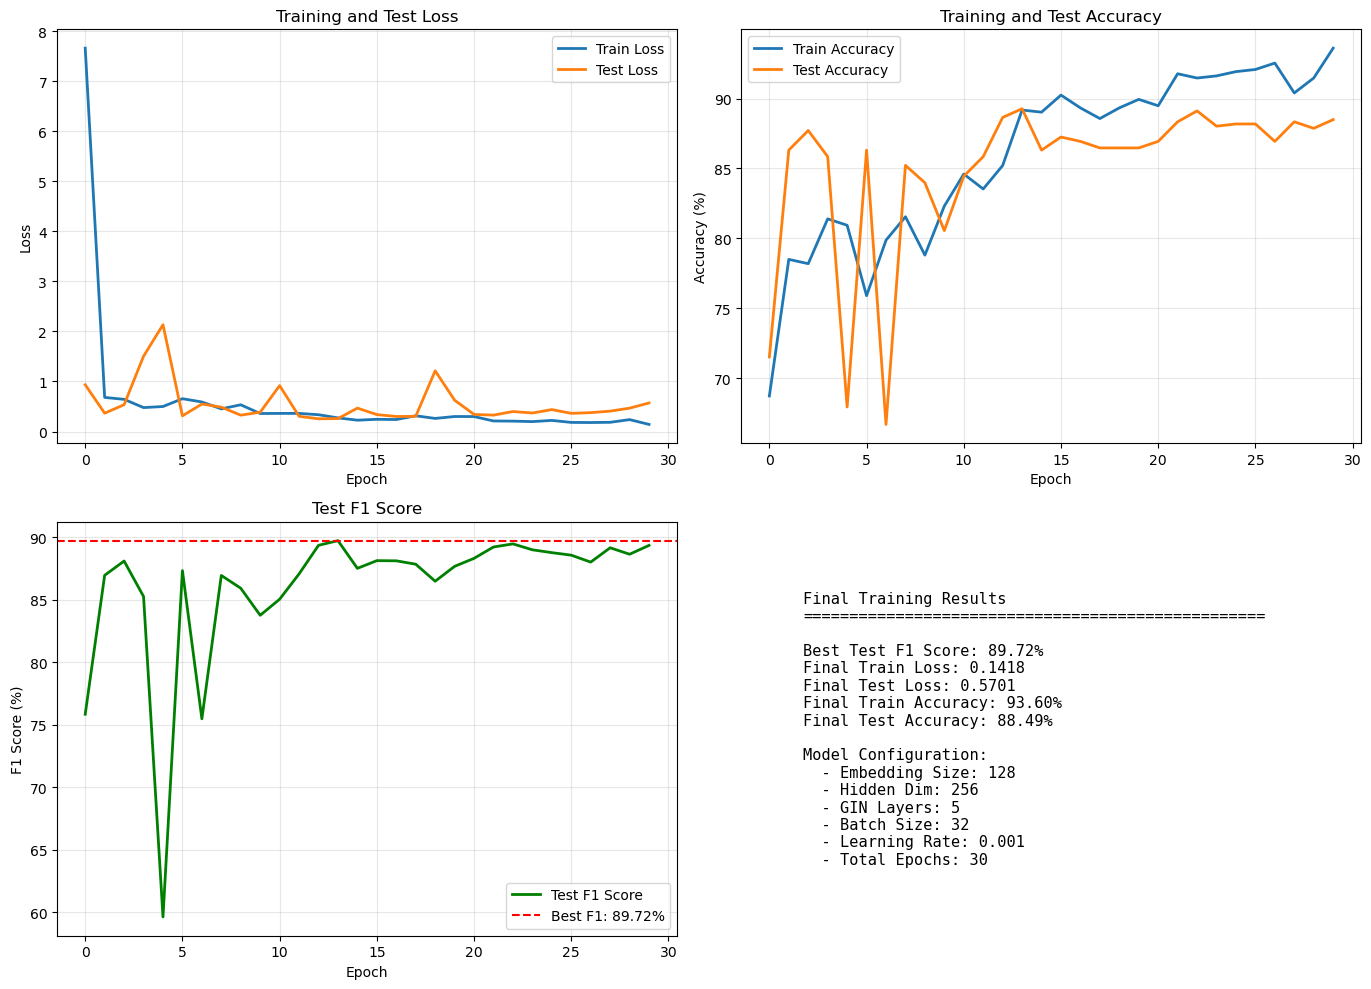

In [ ]:
# Plot training curves
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Loss curves
axes[0, 0].plot(train_losses, label='Train Loss', linewidth=2)
axes[0, 0].plot(test_losses, label='Test Loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Test Loss')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Accuracy curves
axes[0, 1].plot(train_accs, label='Train Accuracy', linewidth=2)
axes[0, 1].plot(test_accs, label='Test Accuracy', linewidth=2)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].set_title('Training and Test Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# F1 curve
axes[1, 0].plot(test_f1s, label='Test F1 Score', linewidth=2, color='green')
axes[1, 0].axhline(y=best_test_f1, color='r', linestyle='--', label=f'Best F1: {best_test_f1:.2f}%')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('F1 Score (%)')
axes[1, 0].set_title('Test F1 Score')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Summary statistics
axes[1, 1].axis('off')
summary_text = f"""
Final Training Results
{'='*50}

Best Test F1 Score: {best_test_f1:.2f}%
Final Train Loss: {train_losses[-1]:.4f}
Final Test Loss: {test_losses[-1]:.4f}
Final Train Accuracy: {train_accs[-1]:.2f}%
Final Test Accuracy: {test_accs[-1]:.2f}%

Model Configuration:
  - Embedding Size: {EMBEDDING_SIZE}
  - Hidden Dim: {HIDDEN_DIM}
  - GIN Layers: {NUM_LAYERS}
  - Batch Size: {BATCH_SIZE}
  - Learning Rate: {LEARNING_RATE}
  - Total Epochs: {NUM_EPOCHS}
"""
axes[1, 1].text(0.1, 0.5, summary_text, fontsize=11, family='monospace',
                verticalalignment='center')

plt.tight_layout()
plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Final Evaluation on Test Set

In [ ]:
# Final evaluation with best model
print("Evaluating best model on test set...\n")
final_metrics = evaluate(model, test_loader, criterion, device)

print("="*70)
print("FINAL TEST SET RESULTS")
print("="*70)
print(f"Accuracy:  {final_metrics['accuracy']:.2f}%")
print(f"Precision: {final_metrics['precision']:.2f}%")
print(f"Recall:    {final_metrics['recall']:.2f}%")
print(f"F1 Score:  {final_metrics['f1']:.2f}%")
print(f"AUC-ROC:   {final_metrics['auc']:.4f}")
print("="*70)

Evaluating best model on test set...



FINAL TEST SET RESULTS
Accuracy:  88.49%
Precision: 85.16%
Recall:    93.94%
F1 Score:  89.34%
AUC-ROC:   0.9614


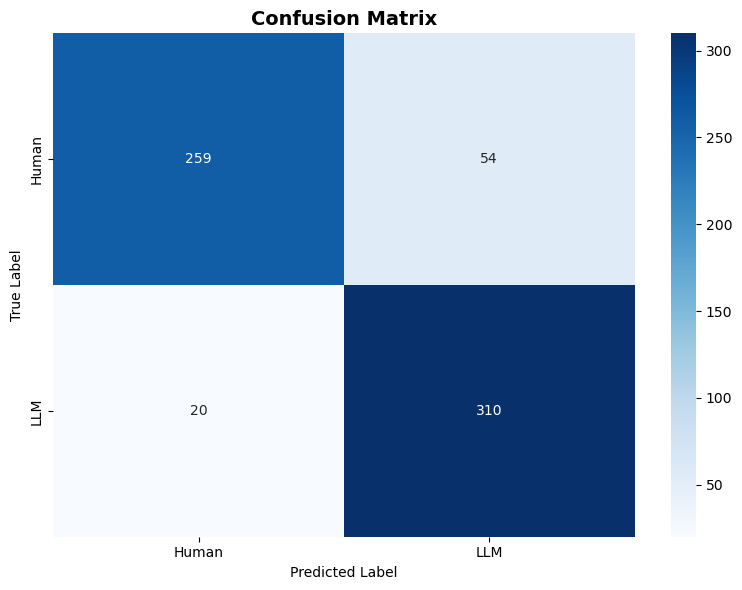


Confusion Matrix:
[[259  54]
 [ 20 310]]


In [ ]:
# Confusion matrix
cm = confusion_matrix(final_metrics['labels'], final_metrics['predictions'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Human', 'LLM'],
            yticklabels=['Human', 'LLM'])
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nConfusion Matrix:")
print(cm)

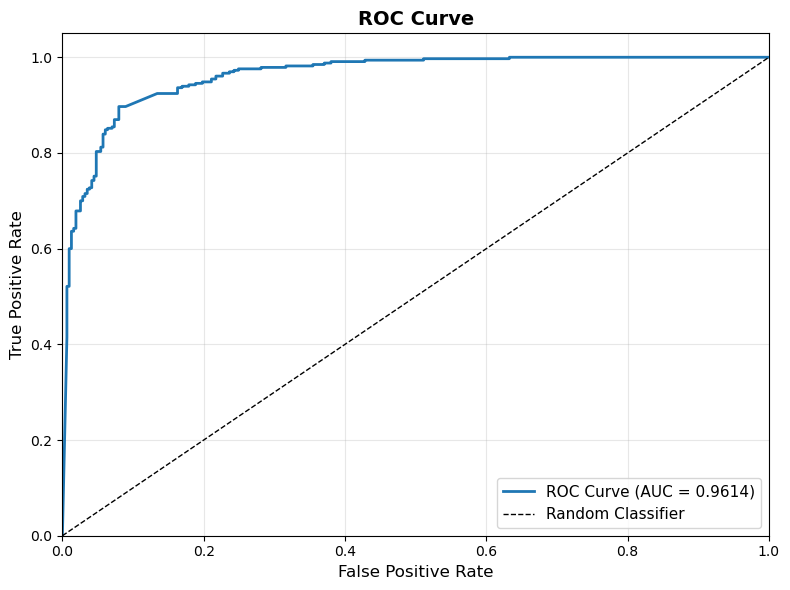

In [ ]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(final_metrics['labels'], final_metrics['probabilities'])

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {final_metrics["auc"]:.4f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curve.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Error Analysis

In [ ]:
# Analyze misclassifications
predictions = np.array(final_metrics['predictions'])
labels = np.array(final_metrics['labels'])
probabilities = np.array(final_metrics['probabilities'])

# Find misclassified samples
misclassified_idx = np.where(predictions != labels)[0]
correct_idx = np.where(predictions == labels)[0]

print(f"Total samples: {len(labels)}")
print(f"Correctly classified: {len(correct_idx)} ({100*len(correct_idx)/len(labels):.2f}%)")
print(f"Misclassified: {len(misclassified_idx)} ({100*len(misclassified_idx)/len(labels):.2f}%)")

# Breakdown by class
human_misclassified = np.where((predictions != labels) & (labels == 0))[0]
llm_misclassified = np.where((predictions != labels) & (labels == 1))[0]

print(f"\nMisclassified breakdown:")
print(f"  Human → LLM: {len(human_misclassified)} (false positives)")
print(f"  LLM → Human: {len(llm_misclassified)} (false negatives)")

Total samples: 643
Correctly classified: 569 (88.49%)
Misclassified: 74 (11.51%)

Misclassified breakdown:
  Human → LLM: 54 (false positives)
  LLM → Human: 20 (false negatives)


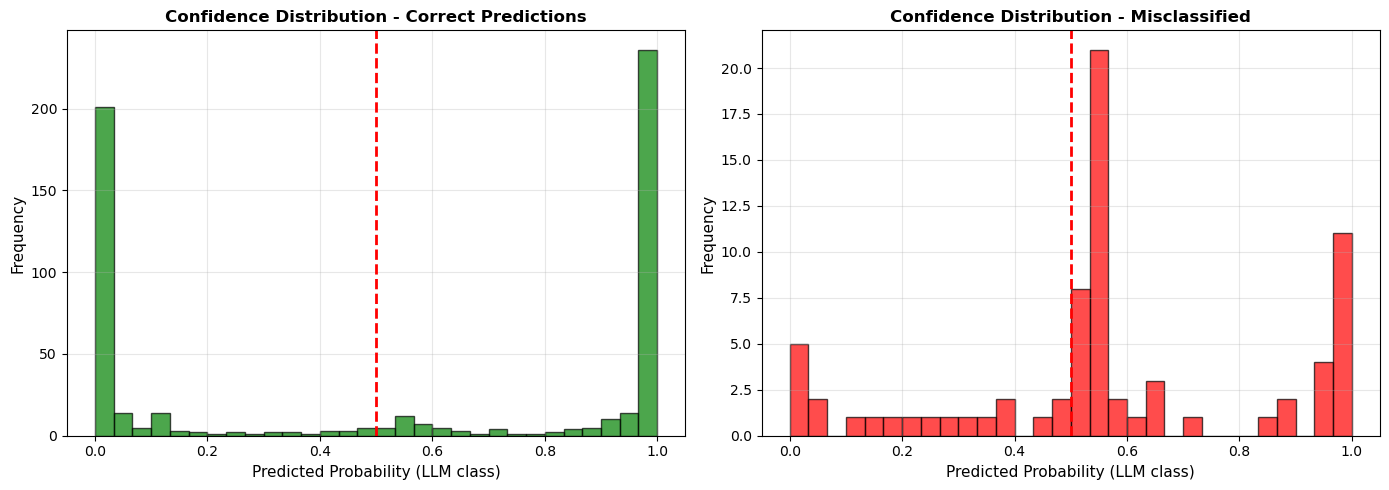

In [ ]:
# Confidence distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confidence for correct predictions
correct_probs = probabilities[correct_idx]
axes[0].hist(correct_probs, bins=30, alpha=0.7, color='green', edgecolor='black')
axes[0].axvline(x=0.5, color='r', linestyle='--', linewidth=2)
axes[0].set_xlabel('Predicted Probability (LLM class)', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title('Confidence Distribution - Correct Predictions', fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3)

# Confidence for misclassified predictions
misclassified_probs = probabilities[misclassified_idx]
axes[1].hist(misclassified_probs, bins=30, alpha=0.7, color='red', edgecolor='black')
axes[1].axvline(x=0.5, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted Probability (LLM class)', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].set_title('Confidence Distribution - Misclassified', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('confidence_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Model Saving and Summary

In [ ]:
# Save complete model checkpoint
checkpoint = {
    'model_state_dict': best_model_state,
    'vocab_size': vocab_size,
    'embedding_dim': EMBEDDING_SIZE,
    'hidden_dim': HIDDEN_DIM,
    'num_layers': NUM_LAYERS,
    'max_nodes': MAX_NODES,
    'best_test_f1': best_test_f1,
    'final_metrics': final_metrics,
    'train_losses': train_losses,
    'test_losses': test_losses,
    'train_accs': train_accs,
    'test_accs': test_accs,
    'test_f1s': test_f1s
}

torch.save(checkpoint, 'checkpoint.pth')
print("Complete checkpoint saved to 'checkpoint.pth'")

Complete checkpoint saved to 'checkpoint.pth'


In [ ]:
# Save results summary
results_summary = {
    'model_config': {
        'embedding_size': EMBEDDING_SIZE,
        'hidden_dim': HIDDEN_DIM,
        'num_layers': NUM_LAYERS,
        'max_nodes': MAX_NODES,
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'num_epochs': NUM_EPOCHS
    },
    'final_metrics': {
        'accuracy': float(final_metrics['accuracy']),
        'precision': float(final_metrics['precision']),
        'recall': float(final_metrics['recall']),
        'f1': float(final_metrics['f1']),
        'auc': float(final_metrics['auc'])
    },
    'confusion_matrix': cm.tolist(),
    'dataset_stats': {
        'train_size': len(valid_dataset),
        'test_size': len(test_dataset),
        'vocab_size': vocab_size
    }
}

with open('results_summary.json', 'w') as f:
    json.dump(results_summary, f, indent=2)

print("Results summary saved to 'results_summary.json'")

Results summary saved to 'results_summary.json'


## 10. Sample Predictions

In [ ]:
# Show some example predictions
num_examples = 5

print("\n" + "="*70)
print("SAMPLE PREDICTIONS")
print("="*70)

for i in range(min(num_examples, len(test_dataset))):
    sample = test_dataset[i]
    
    # Prepare inputs
    code_graph = sample['code_graph'].unsqueeze(0).to(device)
    contrast_graph = sample['contrast_graph'].unsqueeze(0).to(device)
    code_seq = [sample['code_sequence']]
    contrast_seq = [sample['contrast_sequence']]
    code_num_nodes = [sample['code_num_nodes']]
    contrast_num_nodes = [sample['contrast_num_nodes']]
    
    # Get prediction
    model.eval()
    with torch.no_grad():
        logits = model(code_seq, code_graph, code_num_nodes,
                      contrast_seq, contrast_graph, contrast_num_nodes)
        probs = F.softmax(logits, dim=1)
        pred = torch.argmax(logits, dim=1).item()
        confidence = probs[0][pred].item()
    
    true_label = sample['label'].item()
    
    print(f"\nSample {i+1}:")
    print(f"  Index: {sample['index']}")
    print(f"  True Label: {true_label} ({'Human' if true_label == 0 else 'LLM'})")
    print(f"  Predicted: {pred} ({'Human' if pred == 0 else 'LLM'})")
    print(f"  Confidence: {confidence*100:.2f}%")
    print(f"  Code nodes: {sample['code_num_nodes']}, Contrast nodes: {sample['contrast_num_nodes']}")
    print(f"  {'✓ CORRECT' if pred == true_label else '✗ INCORRECT'}")


SAMPLE PREDICTIONS

Sample 1:
  Index: gp333488
  True Label: 1 (LLM)
  Predicted: 1 (LLM)
  Confidence: 100.00%
  Code nodes: 15, Contrast nodes: 31
  ✓ CORRECT

Sample 2:
  Index: gp254519
  True Label: 1 (LLM)
  Predicted: 1 (LLM)
  Confidence: 98.55%
  Code nodes: 8, Contrast nodes: 24
  ✓ CORRECT

Sample 3:
  Index: gp320381
  True Label: 1 (LLM)
  Predicted: 1 (LLM)
  Confidence: 100.00%
  Code nodes: 114, Contrast nodes: 126
  ✓ CORRECT

Sample 4:
  Index: gp162698
  True Label: 0 (Human)
  Predicted: 0 (Human)
  Confidence: 87.22%
  Code nodes: 45, Contrast nodes: 47
  ✓ CORRECT

Sample 5:
  Index: gp187093
  True Label: 1 (LLM)
  Predicted: 1 (LLM)
  Confidence: 99.99%
  Code nodes: 7, Contrast nodes: 32
  ✓ CORRECT
